## Setting things up
add a shortcut to this following folder into your own google drive, so you don't need your local harddrive storage:

https://drive.google.com/drive/folders/10zzTzXgi9CvCEZNw6fG9fsIVjUXNijUu?usp=sharing

The first few lines of this code will mount your drive and read the data via the shortcut. You may need to authorize Colab to read your Drive, just follow the code's output instructions.

**Note** this folder is different from the last exercise folder. We've used the code from the last exercise and generated sliced windows with labels of the orginial dataset.


## Classifying activities with the PAMAP dataset we introduced in exercise 1
Just a refresher:
The corresponding IDs for the activities are:
* 0 -> other (transient activities)
* 1 -> lying
* 2 -> sitting
* 3 -> standing
* 4 -> walking
* 5 -> running
* 6 -> cycling
* 7 -> Nordic walking
* 9 -> watching TV
* 10 -> computer work
* 11 -> car driving
* 12 -> ascending stairs
* 13 -> descending stairs
* 16 -> vacuum cleaning
* 17 -> ironing
* 18 -> folding laundry
* 19 -> house cleaning
* 20 -> playing soccer
* 24 -> rope jumping

Note that not every subject performed all of the activities.

For this exercise, you may have to refer to the sklearn documentation. But we have placed as many comments as possible to guide you.
https://scikit-learn.org/stable/modules/classes.html


In [ ]:
#import the packages that we need
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import itertools
from sklearn import neighbors, metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from scipy.stats import kurtosis, skew

In [ ]:
# Import files from drive
from google.colab import drive
drive.mount('/content/drive')
# this might prompt you to authorize and might take a minute
!cp -r "/content/drive/My Drive/PAMAP2_Dataset/WindowSamples" .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Default file names
fileName = "WindowSamples/subject101.npz"
# Load data from numpy file
data = np.load(fileName)
# first lets see what's in the file
for k in data.iterkeys():
  print(k)
# Skip the first column because it's timestamp
X = data['arr_0'][:,:,1:4] 
y = data['arr_1']
print(X.shape)
print(y.shape)

# Check the activites performed by the subject
print(np.unique(y))
numClass = len(np.unique(y))

arr_0
arr_1
(7413, 200, 3)
(7413,)
[ 0  1  2  3  4  5  6  7 12 13 16 17 24]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: NpzFile.iterkeys is deprecated in python 3, to match the removal of dict.iterkeys. Use .keys() instead.
  


Now let's define some functions to calculate features from time windows so we can reuse it in a loop that goes through the entire dataset window by window

In [ ]:
def f_features ( m_input, numFeatures ): # you will need to increase numFeatures if you want to add more features
  # m_input is an 1D ndarray
  m_norm = f_normalize(m_input)
  m_features = np.zeros( (1,numFeatures) )
  # calculate features. You can also replace the lines already written with your own feature
  m_features[0,0] = m_input.mean() 
  m_features[0,1] = m_input.max() # TODO  
  m_features[0,2] = m_input.min() # TODO 
  m_features[0,3] = m_input.std()  # TODO
  m_features[0,4] = np.fft.fft(m_norm).real.max()
  m_features[0,5] = np.var(m_input) # skew(m_input) # kurtosis(m_input) #  # TODO
  #print(m_features)
  return  m_features
    
def f_normalize ( m_input ):
  # m_input is an 1D ndarray
  m_mu = m_input.mean()
  m_delta = m_input.std()
  return (m_input - m_mu)/m_delta
    
def f_calvector (m_input):
  # m_input is a m-by-3 ndarray
  m_vector = np.zeros( (m_input.shape[0],1) )  
  for i in range(0, m_input.shape[0] ):
      m_vector[i] = np.sqrt( np.sum( np.square(m_input[i,:])) )
  return m_vector

In [ ]:
# Check the shape of 1 window
print(X[0,:,:].shape)
# How many windows we have
print(len(X))

numFeatures = 6
# calculate features for every window, this may take a minute
X_features = np.zeros((len(X),numFeatures))
for i in range(len(X)):
  X_features[i,:] = f_features( f_calvector(X[i,:,:]),numFeatures )
print('X_features shape: ',X_features.shape)

# expected (7413, 6) for subject 1

(200, 3)
7413
X_features shape:  (7413, 6)


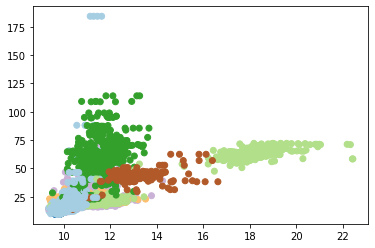

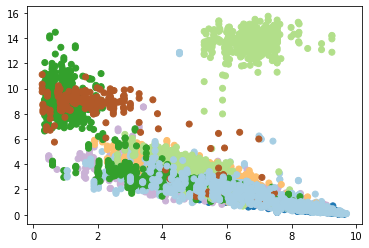

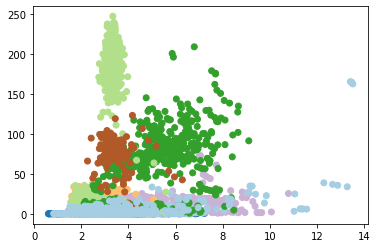

In [ ]:
# let's see how the features are distributed as scatter plots
plt.figure()
plt.scatter(X_features[:,0],X_features[:,1], c=y, cmap=plt.cm.Paired)
plt.figure()
plt.scatter(X_features[:,2],X_features[:,3], c=y, cmap=plt.cm.Paired)
plt.figure()
plt.scatter(X_features[:,4],X_features[:,5], c=y, cmap=plt.cm.Paired)
plt.show()

Output example (but yours is not necessarily the same because you may calculate different features)
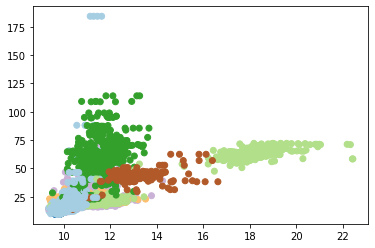


So far we converted the windowed sensor signals to features. There is one feature vector per window that represents the characterisitics of the singals in the window. 

Next we will train a classifier and try to distinguish those activities.

The following block of code is the major part you'll have to fill

In [ ]:
# first define a function to perform k-fold cross-validation with a classifier
def k_fold_validation(X, y, model_type = 'knn', folds = 5):
  numClass = len(np.unique(y))
  #print(X.shape)
  #print(y.shape)

  # why we use StratifiedKFold instead of model_selection.KFold()?
  # This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.
  kf = skl.model_selection.StratifiedKFold(folds)
  

  # make a confusion matrix to hold the sum of all matrices from each fold
  m_cm_All = np.zeros((numClass,numClass))

  for train_index, test_index in kf.split(X, y):
    #print(train_index.shape, test_index.shape)
    # split the training and testing data
    X_train, X_test = X[train_index,:], X[test_index, :]
    y_train, y_test = y[train_index], y[test_index] # TODO

    # define the model
    if model_type == 'knn':
      m_model = skl.neighbors.KNeighborsClassifier() # TODO
    if model_type == 'svm':
      m_model = skl.svm.SVC() # TODO

    # train the model
    m_model.fit(X_train, y_train) # TODO

    # test the model by making predictions with test data
    y_predict = m_model.predict(X_test) # TODO

    # generate confusion matrix from the groundtruth and prediction
    m_cm = skl.metrics.confusion_matrix(y_test, y_predict) # TODO

    # add the confusion matrix to the single summary matrix
    m_cm_All+=m_cm

  return m_cm_All

def plot_confusion_matrix(cm, class_names):
  """
  You can mostly ignore this function
  Returns a matplotlib figure containing the plotted confusion matrix.
  Args:
  cm (array, shape = [n, n]): a confusion matrix of integer classes
  class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(len(class_names)/2, len(class_names)/2))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  acc = np.sum( cm * np.eye(len(class_names)) ) / np.sum(cm)

  plt.title("CM , acc:"+str(round(acc,4)))
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)
  
  # Normalize the confusion matrix.
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
  
  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      color = "white" if cm[i, j] > threshold else "black"
      plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()
  return figure


In [ ]:
#k_fold_validation(X_features, y, model_type = 'knn', folds = 5)

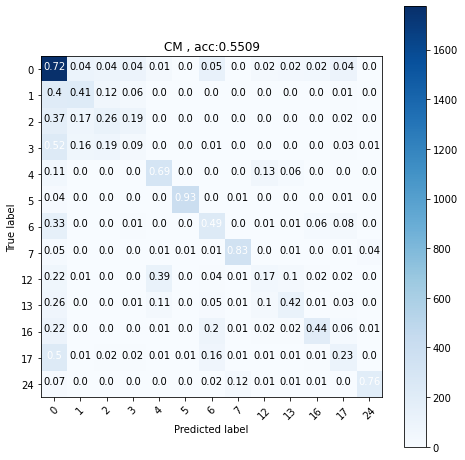

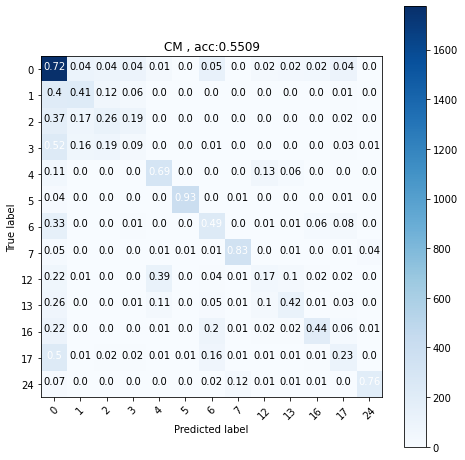

In [ ]:
# now let's call the k-fold validation function with our dataset
m_cm_All = k_fold_validation(X_features, y, model_type = 'knn', folds = 5)
# and plot the confuison matrix
plot_confusion_matrix(m_cm_All, np.unique(y).astype('int'))

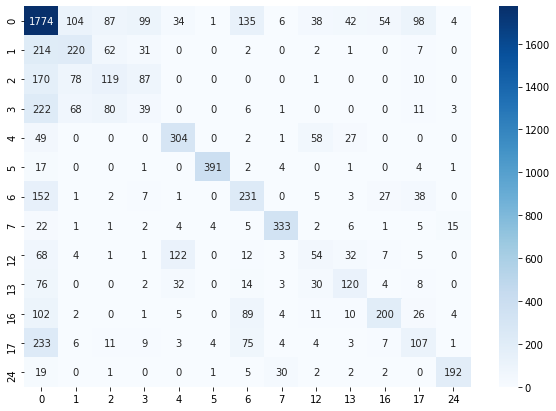

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


df_cm = pd.DataFrame(m_cm_All, index = np.unique(y).astype('int'), columns = np.unique(y).astype('int'))
plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True,cmap='Blues', fmt='g');


The result is rather bad. Most classes are very shallow. If we plot the content of the confusion matrix, we will notice that this is a very imbalanced dataset, meaning class 0 has significantly more (over-represented) samples than the others, and some classes have significantly less (under-represented) than the average.

In [ ]:
print(m_cm_All.astype('int'))
# which of the following is the count of groundtruths and which is predicitons?
print(np.sum(m_cm_All,0))
print(np.sum(m_cm_All,1))
# All lables along the row indicates ground truth and lables along column indictes prediction
# thus np.sum along axis 1 is groundtruth count, because it gives sum of values for each row
# thus np.sum along axis 0 is prediction count, because it gives sum of values for each column

[[1774  104   87   99   34    1  135    6   38   42   54   98    4]
 [ 214  220   62   31    0    0    2    0    2    1    0    7    0]
 [ 170   78  119   87    0    0    0    0    1    0    0   10    0]
 [ 222   68   80   39    0    0    6    1    0    0    0   11    3]
 [  49    0    0    0  304    0    2    1   58   27    0    0    0]
 [  17    0    0    1    0  391    2    4    0    1    0    4    1]
 [ 152    1    2    7    1    0  231    0    5    3   27   38    0]
 [  22    1    1    2    4    4    5  333    2    6    1    5   15]
 [  68    4    1    1  122    0   12    3   54   32    7    5    0]
 [  76    0    0    2   32    0   14    3   30  120    4    8    0]
 [ 102    2    0    1    5    0   89    4   11   10  200   26    4]
 [ 233    6   11    9    3    4   75    4    4    3    7  107    1]
 [  19    0    1    0    0    1    5   30    2    2    2    0  192]]
[3118.  484.  364.  279.  505.  401.  578.  389.  207.  247.  302.  319.
  220.]
[2476.  539.  465.  430.  441.  42

Expected output:



```
[[2210   56   91  268  203    0  223  106   82   92   79  194    5]
 [  73  297   58   18    1    0    3    3    4    5    1    1    0]
 [ 173   76  117   41    1    0    6   12    2    2    0   12    0]
 [ 273    7   22  192    0    0    4    1    0    2    0    6    0]
 [ 194    0    0    0  391    0    1    5   40    0    9    0    6]
 [   3    0    4    0    0  171    1    0    0    1    0    0    0]
 [ 323    5    4    6    0    0   76   16    1   19   26   20    2]
 [ 108    1    3    2    0    0   12  373    9   44   20   16    2]
 [ 153    3    3    3   85    0    4   13   57    9    5    0    3]
 [ 120    5    3    6    1    0   22   51   15   61    1    9    1]
 [ 208    4    0    4   11    0   48   30    5    3   73   23    0]
 [ 280    5    7   10    1    0   45   23    1    6   15  179    1]
 [  29    1    0    2    4    5    4    1    5    1    0    1  208]]
 ```



So we need to balance it now. Here we just use the simplest method - randomly remove samples from the over-represented class until everything is down to the same amount of samples from the least-represented class.

Also we can try skip the class 0 as it is 'transient'

In [ ]:
#first let's count how many samples are in each class.
m_counts = np.zeros((numClass))
m_labels = np.unique(y)
for i in range(0, numClass):
  m_counts[i] = int(sum(y==m_labels[i]))
print(m_counts)

# and the least represented class has how many samples?
m_least = int(m_counts.min())
print(m_least)

[2476.  539.  465.  430.  441.  421.  467.  401.  309.  289.  454.  467.
  254.]
254


expected output for subject 1:


```
[2476.  539.  465.  430.  441.  421.  467.  401.  309.  289.  454.  467.  254.]
254
```
Then we just need to generate a random index for each class and take the first m_least amount of data from that index.


In [ ]:
X_balanced = np.zeros((0, numFeatures)) #note we've changed from X_features to X for simplicity
y_balanced = np.zeros((0)) 
m_least = int(m_counts.min())

for i in range(1, numClass): # note we are jumping over class 0 now
  rand_ind = np.random.permutation(int(m_counts[i]))
  #print(len(rand_ind))
  m_subind = np.where(y==m_labels[i]) # this is the sub-index of the current class in the whole data file
  #print(m_subind[0].shape)
  m_subind_balanced = m_subind[0][rand_ind[:m_least]] # TODO
  #print(len(m_subind_balanced))
                                  
  # add the selected samples from the current class to the overall balanced dataset
  X_balanced = np.concatenate( (X_balanced, X_features[m_subind_balanced,:]) )
  y_balanced = np.concatenate( (y_balanced, y[m_subind_balanced]) ) # TODO
  

# now let's count them again
m_counts_balanced = np.zeros((numClass))
for i in range(1, numClass):
  m_counts_balanced[i] = int(sum(y_balanced==m_labels[i]))
print(m_counts_balanced)

[  0. 254. 254. 254. 254. 254. 254. 254. 254. 254. 254. 254. 254.]


expected output for subject 1:

```
[  0. 254. 254. 254. 254. 254. 254. 254. 254. 254. 254. 254. 254.]
```
Notice now every class should have the same count as the least represented class.

Before jumping back to the cross validation, let's see how balancing has changed the cluster plots

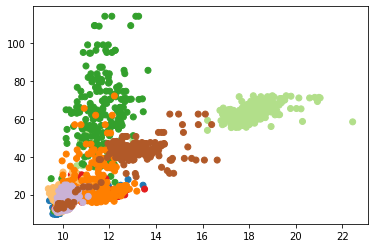

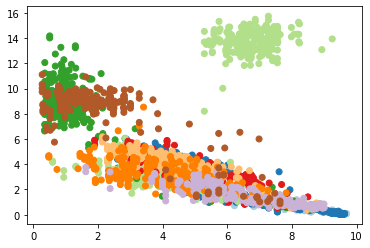

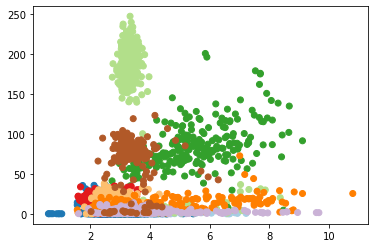

In [ ]:
# let's see how the features are distributed as scatter plots
plt.figure()
plt.scatter(X_balanced[:,0],X_balanced[:,1], c=y_balanced, cmap=plt.cm.Paired)
plt.figure()
plt.scatter(X_balanced[:,2],X_balanced[:,3], c=y_balanced, cmap=plt.cm.Paired)
plt.figure()
plt.scatter(X_balanced[:,4],X_balanced[:,5], c=y_balanced, cmap=plt.cm.Paired)
plt.show()

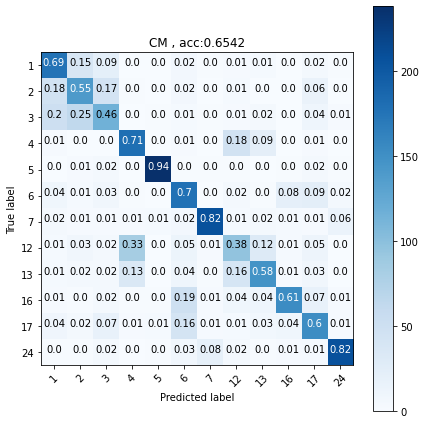

[[176.  38.  22.   0.   0.   6.   1.   2.   3.   0.   5.   1.]
 [ 46. 140.  43.   1.   0.   6.   0.   3.   0.   0.  15.   0.]
 [ 51.  63. 116.   0.   1.   3.   1.   2.   4.   0.  11.   2.]
 [  2.   0.   0. 180.   0.   2.   0.  45.  23.   0.   2.   0.]
 [  0.   2.   4.   0. 238.   1.   1.   1.   0.   1.   5.   1.]
 [  9.   3.   8.   1.   0. 178.   0.   5.   1.  21.  24.   4.]
 [  5.   2.   2.   2.   3.   6. 208.   3.   4.   3.   2.  14.]
 [  3.   8.   4.  83.   0.  13.   2.  96.  30.   3.  12.   0.]
 [  3.   4.   4.  34.   0.  11.   1.  40. 147.   2.   8.   0.]
 [  2.   1.   5.   1.   1.  49.   2.   9.  11. 154.  17.   2.]
 [ 10.   5.  17.   2.   3.  41.   2.   3.   7.   9. 153.   2.]
 [  1.   1.   5.   0.   1.   8.  20.   4.   1.   2.   3. 208.]]
[308. 267. 230. 304. 247. 324. 238. 213. 231. 195. 257. 234.]
[254. 254. 254. 254. 254. 254. 254. 254. 254. 254. 254. 254.]


In [ ]:
#now let's try the cross validation again with the balanced data
m_cm_All = k_fold_validation(X_balanced, y_balanced, model_type = 'knn', folds = 5)
plot_confusion_matrix(m_cm_All, np.unique(y_balanced).astype('int'))
print(m_cm_All)
# which of the following is the count of groundtruths and which is predicitons?
print(np.sum(m_cm_All,0))
print(np.sum(m_cm_All,1))

Example result (again, your result may be very different)

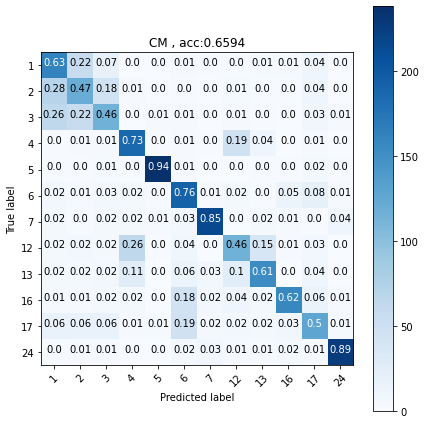



```
[[161.  56.  18.   0.   0.   2.   1.   1.   3.   2.  10.   0.]
 [ 70. 120.  45.   2.   0.   1.   0.   3.   1.   1.  11.   0.]
 [ 65.  56. 116.   0.   2.   2.   0.   2.   1.   0.   8.   2.]
 [  1.   2.   2. 186.   1.   2.   1.  47.  10.   0.   2.   0.]
 [  1.   1.   3.   1. 238.   2.   0.   0.   1.   1.   5.   1.]
 [  6.   2.   7.   4.   1. 192.   2.   4.   1.  13.  20.   2.]
 [  4.   1.   4.   4.   2.   7. 215.   0.   4.   2.   1.  10.]
 [  5.   6.   5.  65.   1.   9.   0. 116.  38.   2.   7.   0.]
 [  5.   5.   6.  27.   0.  14.   7.  26. 154.   0.  10.   0.]
 [  2.   2.   5.   4.   0.  45.   6.  10.   5. 158.  15.   2.]
 [ 16.  16.  16.   2.   3.  47.   4.   6.   5.   8. 128.   3.]
 [  1.   2.   2.   0.   0.   5.   8.   2.   2.   4.   2. 226.]]
```



# Epilogue

In this exercise we've seenhow to classify activities from temporal sensor data with calculating features and classifiers in the k-fold partitioning scheme.

We also see in real-world datasets imbalancing is a real problem for the classifier. We've overcomed this by randomly undersampling but there are more techniques out there to counter this problem.

You can try calculate different features and also increase the amount of features, as well as trying other classifiers from sklearn, to see if you can get better result.

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

Also, we've only tested on subject 1. You can switch the file name and test on other subjects.